In this notebook we will apply TSNE by sampling 2000 datapoints from each class(As TSNE is computationally expensive)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

In [2]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
%cd /content/gdrive/MyDrive/Notebooks/


/content/gdrive/MyDrive/Notebooks


# Loading the processed data

In [2]:
df = pd.read_csv('processed_df.csv')
df = df.dropna(axis=0)
print(df.shape)
df.head()

(363184, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [5]:
df['Score'].value_counts()

1    306195
0     56989
Name: Score, dtype: int64

In [6]:
df1 = df[df['Score'] == 1].sample(2000)
df0 = df[df['Score'] == 0].sample(2000)
dff = pd.concat([df1,df0],axis=0)
df = dff.sample(frac=1).reset_index(drop=True)
df.head(3)

,Time,clean_text,Score
0,1272067200,love chips best snack ever top healthy combo,1
1,1313884800,ignore little pearls litter type specific item...,1
2,1161993600,one items want keep pantry fast satisfying mea...,1


# BOW

In [7]:
preprocessed_reviews = df['clean_text'].values

In [8]:
#BoW
count_vect = CountVectorizer(max_features=2000) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_vector = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(bow_vector))
print("the shape of out text BOW vectorizer ",bow_vector.get_shape())
print("the number of unique words ", bow_vector.get_shape()[1])

some feature names  ['able', 'absolutely', 'acai', 'acceptable', 'according', 'acid', 'across', 'active', 'actual', 'actually']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 2000)
the number of unique words  2000


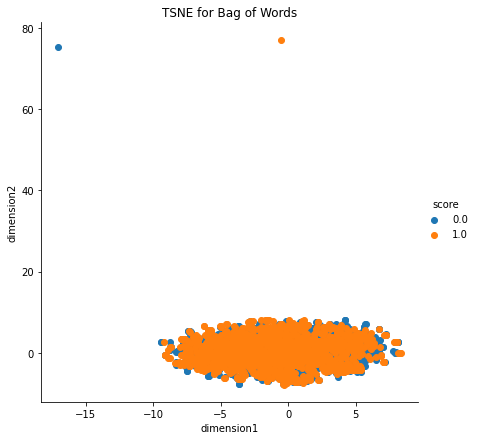

In [9]:
tsne = TSNE(n_components=2,perplexity=60,n_iter=2500)
tsne_result = tsne.fit_transform(bow_vector)
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

# TFIDF

In [10]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=2000)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'absolutely no', 'according', 'acid', 'across', 'actual', 'actually', 'add', 'added']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 2000)
the number of unique words including both unigrams and bigrams  2000


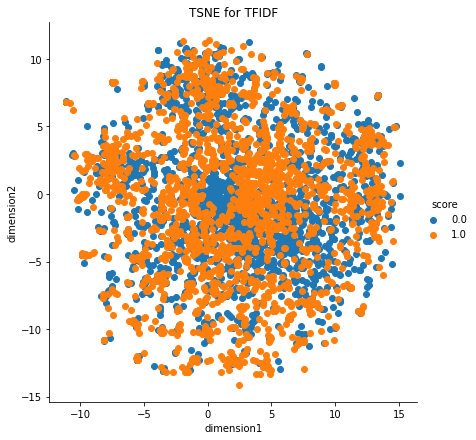

In [11]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(final_tf_idf)
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for TFIDF")
plt.show()

# Word2Vec

In [12]:
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model_train.wv.vocab)

# Avg Word2vec

In [13]:
train_ = train_sentence
sent_vectors_train = []
for sent in tqdm(train_):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1125.40it/s]

4000
50


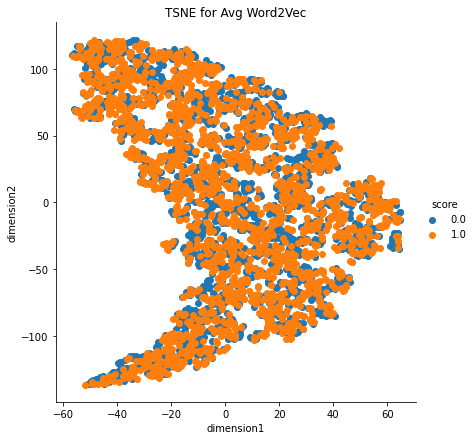

In [14]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(np.array(sent_vectors_train))
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Avg Word2Vec")
plt.show()

# TFIDF W2v

In [15]:
tfidf = TfidfVectorizer()
tfidf.fit(preprocessed_reviews)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

train_sentence = [rev.split() for rev in preprocessed_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:21<00:00, 186.53it/s]

4000
[-0.26158479 -0.58662292  0.13692924  0.59427112 -0.06167    -0.03834775
 -0.15590702 -0.48693532 -0.17419497  0.58180368 -0.61547748  0.28308608
  0.01571039 -0.09425586  0.3138166  -0.61713569 -0.92895902  0.75676289
  0.5101472  -0.01680268  0.57260886 -0.24340581  0.2970043   0.08530761
  0.34439846  0.01265985 -0.33651227  0.95747376 -0.09369027  0.11473743
 -0.6677931   0.68818434  0.14557145 -0.20820062  0.20122834 -0.01086119
 -0.366659   -0.19551365 -0.43638694  0.02593121 -0.04310547 -0.62857976
 -0.1855085  -0.29797036  0.13576249  0.3794299   0.61940255  0.05208299
 -0.14582125 -0.06870889]


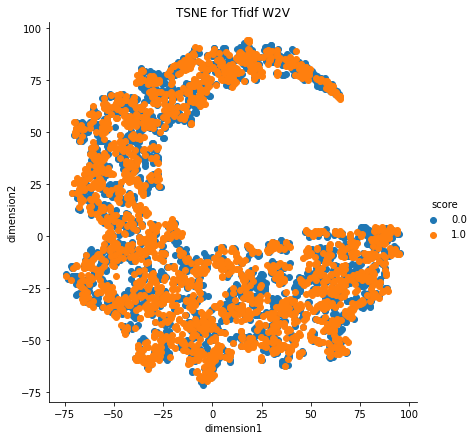

In [16]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(np.array(sent_vectors_train))
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Tfidf W2V")
plt.show()

Steps I followed for TSNE: 

* Keeping perplexity constant ran TSNE at different iterations and found most stable iteration.
* Now keeping that iteration ran TSNE at diifferent perplexity to get a better result.
* Once i got stable result, ran TSNE again with same parameters 

# Observation: 
None of the figures clearly seperate positive and negative reviews well